## Harrison Durbin  
## Worldwide Happiness Survey Data  

In [36]:
import brewer2mpl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier
from geonamescache import GeonamesCache
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn import cross_validation

%matplotlib inline
color = sns.color_palette()
sns.set(style="white", palette="muted", color_codes=True)
pd.set_option('display.max_columns', 120)
pd.options.mode.chained_assignment = None  # default='warn'

In [10]:
def cleanData(df):
    print '------------------------------------------------------------------'
    print 'Removing errant and missing survey responses...'
    # delete row from array if values are missing/inaccurate in the survey
    # column numbers are referenced from features list below
    for col in df.columns:
        raw_temp = df[df[col] > 0]
        df = raw_temp
    df_clean = df
    print '...There are now {} rows of data remaining.'.format(len(df_clean))
    return df_clean

def splitData(df):
    print '------------------------------------------------------------------'
    print 'Splitting data into test and train sets...'
    kf = cross_validation.KFold(n=len(df), n_folds=3,
                                shuffle=True, random_state=None)
    for train_index, test_index in kf:
        dftrain, dftest = df.ix[train_index,:], df.ix[test_index,:]
    print '...There are {} rows of {} data.'.format(dftrain.shape[0], 'train')
    print '...There are {} rows of {} data.'.format(dftest.shape[0], 'test')
    return dftrain, dftest

def featuresTarget(tr,te):
    print '------------------------------------------------------------------'
    print 'Separating the features and target...'
    ## This is a list of the important features to extract from raw data
    target_col = 'happiness'
    feature_cols = list(df_happiness_corr['desc'])
    target_train = tr[target_col]
    target_test = te[target_col]
    features_train = tr[feature_cols]
    features_test = te[feature_cols]
    return features_train, features_test, target_train, target_test

def createModel(type='nn'):
    print '------------------------------------------------------------------'
    print 'Training a predictive model...'
    if type == 'rf':
        model = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=10)
    elif type == 'dt':
        model =  DecisionTreeClassifier(min_samples_split=20, random_state=99)
    elif type == 'nn':
        model = KNeighborsClassifier(n_neighbors=10)
    else:
        print 'Error: No model type selected!'
        sys.exit()
    clf = model.fit(feat_tr.as_matrix(), tar_tr.values)
    return clf

def makePredictions(clf, testfeatures):
    print '------------------------------------------------------------------'
    print 'Making predictions...'
    predictions = clf.predict(testfeatures)    
    return predictions

def getCV(preds, testtarget):
    print '------------------------------------------------------------------'
    print 'Cross-validating the predictions with training data targets...'
    cv = []
    correct = 0
    for row in range(len(preds)):
        cv.append((((preds[row]) - testtarget[row])**2)**0.5)
        if preds[row] == testtarget[row]:
            correct += 1
    cv_score = (100-round(np.mean(cv)*100/np.mean(testtarget)))/100
    accuracy_score = round(correct*100/len(preds),2)
    # print 'When using the {} algorithm:'.format(algorithm_dict[algorithm])
    print 'The RMSE is {}.'.format(cv_score)
    print 'The prediction accuracy is {}%.'.format(accuracy_score)
    return accuracy_score, cv_score

def groupCountries(df, col='happiness'):
    print '------------------------------------------------------------------'
    print 'Grouping surveys into country groups...'
    avg_data = df.groupby('abbr3')[col].mean().sort_values()
    df_avg_data = pd.DataFrame(avg_data)
#     df_avg_data = df_avg_data.ix[iso3_codes].dropna()
#     df_avg_data = df_avg_data[df_avg_data.index != 'EGY']
    return df_avg_data

def makeMap(df, desc, col='happiness'):
    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())
    shapefile = 'country_shapefiles/ne_10m_admin_0_countries_lakes'
    num_colors = 9
    title = 'Country Happiness Level {}'.format(desc)
    imgfile = r'img\{}.png'.format(desc)
    descripton = '''
    A map indicating the {} average reported happiness level for countries across the world based on the 2016 World Value Survey. The 
    max happiness is 1 and min is 4.
    '''.format(desc.lower())
    values = df[col]
    bmap = brewer2mpl.get_map('YlOrRd', 'sequential', 9)
    cm = bmap.get_mpl_colormap(N=1000, gamma=2.0)
    scheme = [cm(i / float(num_colors)) for i in range(num_colors)]
    bins = np.linspace(values.min(), values.max(), num_colors)
    df['bin'] = np.digitize(values, bins) - 1
    mpl.style.use('seaborn-white')
    fig = plt.figure(figsize=(22, 12))
    ax = fig.add_subplot(111, axisbg='w', frame_on=False)
    fig.suptitle('Happiness Levels {}'.format(desc), fontsize=30, y=.95)
    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')
    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in df.index:
            color = '#dddddd'
        else:
            color = scheme[int(df.ix[iso3]['bin'])]
        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)
    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)
    # Draw color legend.
    ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
    cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])
    # Set the map footer.
    plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')
    plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
    return plt






### Importing raw datasets

In [4]:
# data set from World Value Survey
df_raw = pd.read_csv(r'data\WV6.csv', low_memory = False)

In [5]:
df_corr=df_raw.corr().abs()
happiness_corr = df_corr[df_corr['V10']!=1]['V10'].sort_values(ascending=False)

In [6]:
desc =['satisfied','health','householdfinances','neighborrace','neighborimmigrant', \
      'lifecontrol', 'region', 'neighborhoodsecurity', 'countryhumanrights', \
       'incomescale', 'class', 'neighbordiffreligion', 'neighborunmarriedcpl', \
       'leisureimport' ]

In [7]:
df_happiness_corr = pd.DataFrame(happiness_corr)[0:14]
df_happiness_corr['desc'] = desc
df_happiness_corr = df_happiness_corr.drop(['V23','V256C'])
df_happiness_corr.rename(columns = {'V10':'happyinesscorrelation'})

,happyinesscorrelation,desc
V11,0.353282,health
V59,0.246206,householdfinances
V37,0.199243,neighborrace
V39,0.194472,neighborimmigrant
V55,0.177084,lifecontrol
V170,0.146254,neighborhoodsecurity
V142,0.146103,countryhumanrights
V239,0.133850,incomescale
V238,0.133135,class
V41,0.131984,neighbordiffreligion


In [8]:
df_trimmed=df_raw[df_happiness_corr.index]
df_trimmed.columns = df_happiness_corr['desc']
df_trimmed['happiness'] = df_raw['V10']
df_trimmed['cntrycode'] = df_raw['V2A']
df_trimmed.head()

desc,health,householdfinances,neighborrace,neighborimmigrant,lifecontrol,neighborhoodsecurity,countryhumanrights,incomescale,class,neighbordiffreligion,neighborunmarriedcpl,leisureimport,happiness,cntrycode
0,1,10,2,2,7,2,2,5,4,2,1,1,2,12
1,2,10,2,2,6,2,3,6,3,2,2,3,2,12
2,2,6,2,2,6,2,2,6,4,1,1,2,2,12
3,1,6,2,2,6,1,3,5,4,2,1,3,2,12
4,3,4,2,1,6,2,3,7,3,2,1,1,1,12


In [9]:
df_trimmed.describe()

desc,health,householdfinances,neighborrace,neighborimmigrant,lifecontrol,neighborhoodsecurity,countryhumanrights,incomescale,class,neighbordiffreligion,neighborunmarriedcpl,leisureimport,happiness,cntrycode
count,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000,86272.000000
mean,2.077627,5.876032,1.704528,1.643720,6.954585,1.839832,2.168374,4.660400,3.147707,1.608668,1.551407,1.847506,1.835057,487.474036
std,0.880559,2.533436,0.863182,0.875363,2.443487,0.930467,1.303660,2.392559,1.250020,1.107369,1.110843,0.907965,0.799720,259.299426
min,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,12.000000
25%,1.000000,4.000000,2.000000,1.000000,6.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,1.000000,275.000000
50%,2.000000,6.000000,2.000000,2.000000,7.000000,2.000000,2.000000,5.000000,3.000000,2.000000,2.000000,2.000000,2.000000,504.000000
75%,3.000000,8.000000,2.000000,2.000000,9.000000,2.000000,3.000000,6.000000,4.000000,2.000000,2.000000,2.000000,2.000000,710.000000
max,4.000000,10.000000,2.000000,2.000000,10.000000,4.000000,4.000000,10.000000,5.000000,2.000000,2.000000,4.000000,4.000000,901.000000


In [11]:
df_clean = cleanData(df_trimmed)

------------------------------------------------------------------
Removing errant and missing survey responses...
...There are now 73097 rows of data remaining.


In [12]:
df_countries = pd.read_csv(r'data\country_list.csv', header=None)
df_countries.columns = ['countryname','abbr2','abbr3','cntrycode','lat','lng']
df_all = pd.merge(df_clean,df_countries)

In [14]:
tr,te = splitData(df_all)

------------------------------------------------------------------
Splitting data into test and train sets...
...There are 47486 rows of train data.
...There are 23742 rows of test data.


In [15]:
print 'The number of unique countries in clean set is {}.'.format( df_all['cntrycode'].unique().shape[0])
print '...in train set is {}.'.format(tr['cntrycode'].unique().shape[0])
print '...in test set is {}.'.format(te['cntrycode'].unique().shape[0])

The number of unique countries in clean set is 56.
...in train set is 56.
...in test set is 56.


In [17]:
feat_tr, feat_te, tar_tr, tar_te = featuresTarget(tr,te)

------------------------------------------------------------------
Separating the features and target...


In [19]:
clf = createModel()

------------------------------------------------------------------
Training a predictive model...


In [41]:
# Dump the trained classifier with Pickle
pkl_filename = 'classifier.pkl'
# Open the file to save as pkl file
model_pkl = open(pkl_filename, 'wb')
pickle.dump(clf, model_pkl)
# Close the pickle instances
model_pkl.close()

In [23]:
predictions = makePredictions(clf, feat_te)
te['predictions'] = predictions

------------------------------------------------------------------
Making predictions...


In [25]:
scores = getCV(predictions,tar_te.values)

------------------------------------------------------------------
Cross-validating the predictions with training data targets...
The RMSE is 0.74.
The prediction accuracy is 57.0%.


In [27]:
tr_avg_cntry_hap = groupCountries(tr)

------------------------------------------------------------------
Grouping surveys into country groups...


In [28]:
te_avg_cntry_hap = groupCountries(te)

------------------------------------------------------------------
Grouping surveys into country groups...


In [29]:
te_avg_cntry_hap['predictions'] = groupCountries(te, col = 'predictions')['predictions']

------------------------------------------------------------------
Grouping surveys into country groups...


<module 'matplotlib.pyplot' from 'C:\Users\Harrison\Anaconda\lib\site-packages\matplotlib\pyplot.pyc'>

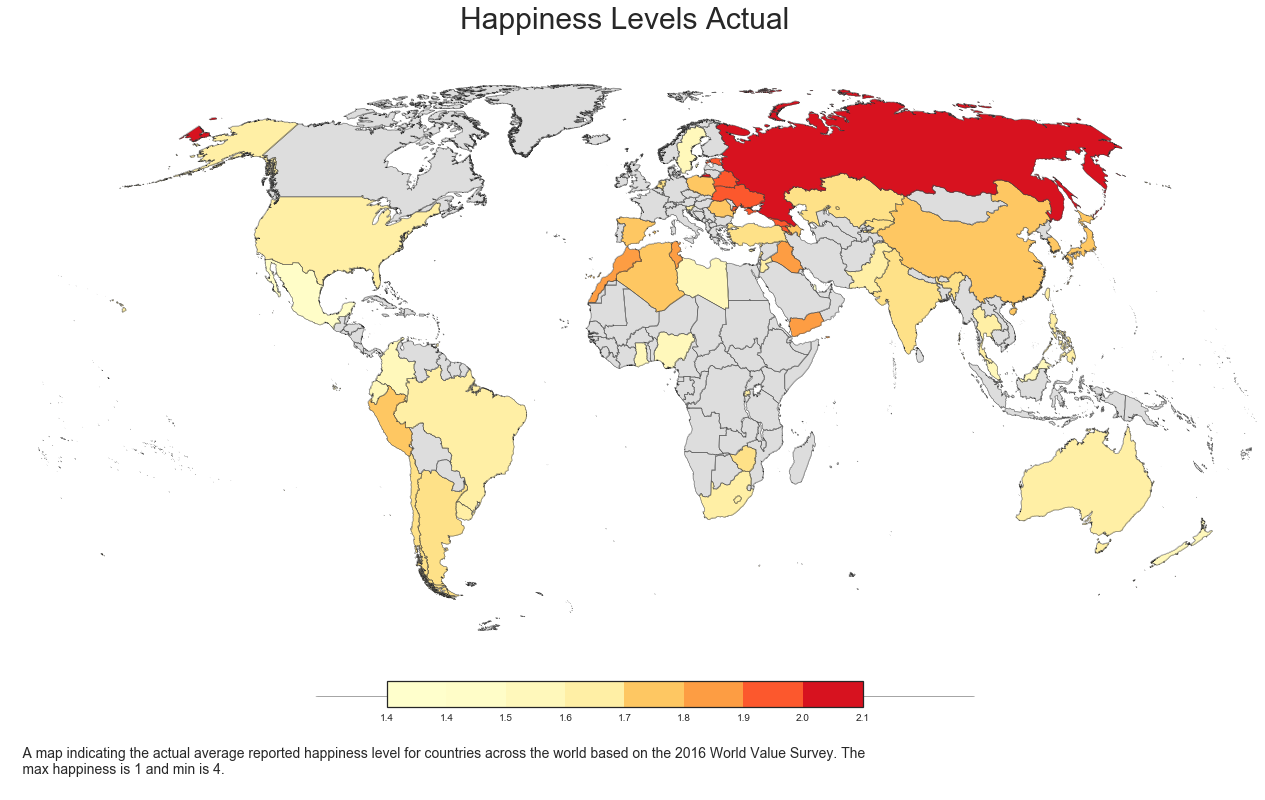

In [39]:
makeMap(te_avg_cntry_hap, 'Actual', col='predictions')

<module 'matplotlib.pyplot' from 'C:\Users\Harrison\Anaconda\lib\site-packages\matplotlib\pyplot.pyc'>

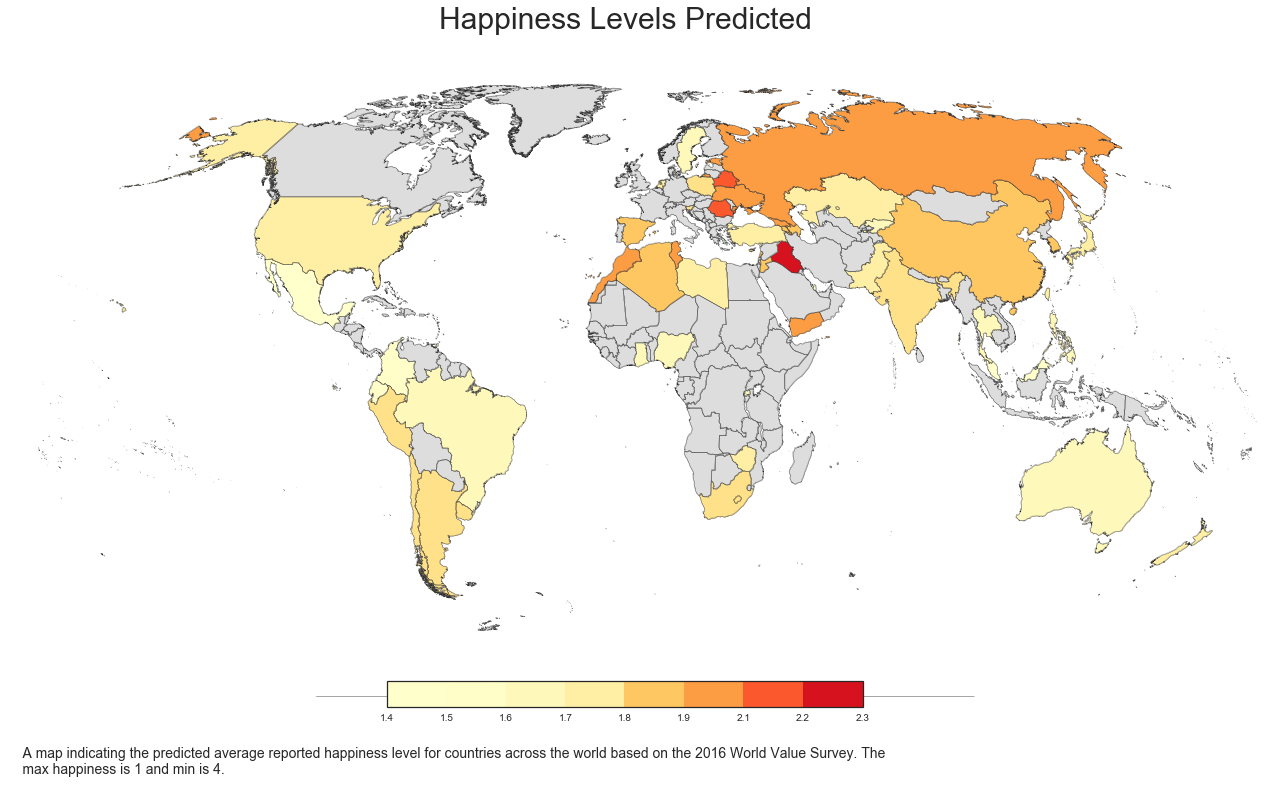

In [40]:
makeMap(te_avg_cntry_hap, 'Predicted', col='happiness')